## CS 169 - HW 3
## Sanath Nair

### Preface

For this problem I implemented the Quasi-Newton Method in python using the same base class template from the previous project. Below is the code from the previous hw to simplify implementation in this hw.

In [2]:
import math

def bracket_minimum(f, x=0, s=1e-2, k=2.0):
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    
    if yb > ya:
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    
    func_evals = 2
    while True:
        c, yc = b + s, f(b + s)
        func_evals += 1
        if yc > yb:
            return (a, c, func_evals) if a < c else (c, a, func_evals)
        
        a, ya, b, yb = b, yb, c, yc
        s *= k

def optimizer1D(func, a, b, tol=1e-3):
    gr = (math.sqrt(5) - 1) / 2 

    x1 = a + (1 - gr) * (b - a)
    x2 = a + gr * (b - a)

    f1 = func(x1)
    f2 = func(x2)
    func_evals = 2
    while abs(b - a) > tol:
        if f1 < f2:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + (1 - gr) * (b - a)
            f1 = func(x1)
        else:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + gr * (b - a)
            f2 = func(x2)
        func_evals += 1

    return (a + b) / 2 , func_evals

Since I'm using Python for this project I will make a base class similar to what was done in the K&W book with Julia. Using this base class I will create children class that inherit from it. In addition I will be using numpy arrays to improve the performance of my code.

In [72]:
# abstract base class package
from abc import ABC, abstractmethod # abstractmethods must be implemented by children classes
# numpy package
import numpy as np
from time import perf_counter # used for calculating exection time

class DescentMethod(ABC):
    
    def __init__(self) -> None:
        super().__init__()
        self.points = np.array([])

    @abstractmethod
    def minimize(self, func, x0, fprime):
        pass
    
    # helper functions to make implementation of descent algorithms easier
    
    def magnitude(self, vector):
        # linalg -> linear algebra subpackage in numpy
        return np.linalg.norm(vector)

### 1)

Below is a QuasiNewton optimizer using the L-BFGS algorithim to approximate the hessian. The code below was severely modified from ChatGPT in order to conform to the inputs and outputs for this assignment.

In [40]:
class QuasiNewton(DescentMethod):
    def __init__(self, alpha=0.01, ep=1e-4) -> None:
        super().__init__()
        self.alpha = alpha
        self.ep = ep

    def line_search(self, func, gradient, x, p):
        alpha = self.alpha
        c = 0.5
        rho = 0.5
        func_evals = 0
        while func(*(x + alpha * p)) > func(*x) + c * alpha * np.dot(gradient(*x), p):
            alpha *= rho
            func_evals += 3
        return alpha, func_evals

    def minimize(self, func, x0, fprime):
        start = perf_counter()
        m = len(x0)
        H = np.identity(m)
        x = x0
        self.points = x

        grad = fprime(*x)

        g_magnitude = self.magnitude(grad)
        prev_magnitude = 0

        func_evals = 1
        while abs(g_magnitude - prev_magnitude) > self.ep:
            p = -np.dot(H, grad)
            alpha, f_evals = self.line_search(func, fprime, x, p)

            s = alpha * p
            x_new = x + s
            y = fprime(*x_new) - grad

            rho = 1 / np.dot(y, s)
            A = np.identity(len(x)) - rho * np.outer(s, y)
            H = np.dot(A.T, np.dot(H, A)) + rho * np.outer(s, s)

            x = x_new
            
            prev_magnitude = g_magnitude
            grad = fprime(*x_new)
            g_magnitude = self.magnitude(grad)

            func_evals += f_evals + 2
            self.points = np.vstack((self.points, x))
            
        end = perf_counter()

        return x, abs(g_magnitude - prev_magnitude), end - start, func_evals

The code below is from HW2. In order to measure the difference I wanted to use the same test functions and starting values.

Below is a generic implementation of the Rosenbrcok function with default values of `a=1` and `b=5`

In [5]:
def rosenbrock_generator(*, a=1, b=5):
    """
    arguments a, b must be passed as keyword arguments
    """
    def rosenbrock(*args):
        total = 0
        for i in range(len(args) - 1):
            x1 = args[i]
            x2 = args[i+1]
            total += (a - x1)**2 + b*(x2 - (x1**2))**2
        return total
    
    return rosenbrock

def rosenbrock_gradient_generator(*, a=1, b=5):
    """
    arguments a, b must be passed as keyword arguments
    """
    def rosenbrock_gradient(*args):
        dx1 = -2*(a-args[0]) + 2*b*(args[1]-args[0]**2)*(-2*args[0])
        gradients = [dx1]
        for i in range(1, len(args) - 1):
            x_prev = args[i-1]
            x = args[i]
            x_next = args[i+1]
            dxn = 2*b*(x - x_prev**2) - 2*(a-x) - 4*b*x*(x_next - x**2)*x
            gradients.append(dxn)
        dxn = 2 * b * (args[-1] - args[-2]**2)
        gradients.append(dxn)
        return np.array(gradients)

    return rosenbrock_gradient

For the second function I used Booth's Function from K&W (p. 429). The equation is as follows: 
$ f(\mathbf{x}) = \sum_{i=1}^{n-1} \left[ (x_i + 2x_{i+1} - 7)^2 + (2x_i + x_{i+1} - 5)^2 \right] $

In [6]:
def booths(*args):
    result = 0
    for i in range(len(args) - 1):
        term = (args[i] + (2 * args[i + 1]) - 7)**2 + ((2 * args[i]) + args[i + 1] - 5)**2
        result += term
    return result

def booths_gradient(*args):
    n = len(args)
    gradient = np.zeros(n)

    # Compute the gradient for the first dimension
    gradient[0] = (2 * (args[0] + 2 * args[1] - 7)) + (4 * (2 * args[0] + args[1] - 5))

    # Compute the gradient for the intermediate dimensions
    for i in range(1, n - 1):
        term = (4 * (args[i-1] + 2 * args[i] - 7)) + (2 * (2 * args[i-1] + args[i] - 5))
        term2 = (2 * (args[i] + 2 * args[i+1] - 7)) + (4 * (2 * args[i] + args[i+1] - 5))
        gradient[i] = term + term2

    # Compute the gradient for the last dimension
    gradient[n - 1] = (4 * (args[n - 2] + 2 * args[n - 1] - 7)) + (2 * (2 * args[n - 2] + args[n - 1] - 5))

    return gradient

The function below takes a list of different starting points and runs the gradient descent method collecting data and returning it back. 

***NOTE: (One limitation is that we don't know the true minimum for higher dimension functions so we cannot measure absolute error)***

In [65]:
import pandas as pd

def run_test(func, gradient, starting_points, / , alpha=0.01, dimensions=10):
    descent = QuasiNewton(alpha=alpha)

    data = []
    for starting_point in starting_points:
        res = descent.minimize(func, starting_point , gradient)

        data.append(res[1:])

    columns = ['convergence measure', 'wall time', 'func evals']
    df = pd.DataFrame(data, columns=columns)
    
    mean_std = df.agg(['mean', 'std'])

    # Concatenate the results into a new DataFrame for comparison
    return mean_std.T

For the starting points since the Rosenbrock's minimum is at (1,1...,1) and a 2D Booth's is at (1,3) I will randomly generate points in the range of (-4, 4).

In [8]:
def generate_starting_points(N, dim, lower, upper):
    random_arrays = []

    for _ in range(N):
        # Generate a random array of size D with values between lower and upper
        random_array = np.random.uniform(lower, upper, dim)
        random_arrays.append(random_array)

    return random_arrays

starting_points = generate_starting_points(50, 10, -4, -4)

In [73]:
rosenbrock = rosenbrock_generator()
rosenbrock_gradient = rosenbrock_gradient_generator()

run_test(rosenbrock, rosenbrock_gradient, starting_points)

/var/folders/dj/vw04h2dn4j1ddd_kybw6fhkc0000gn/T/ipykernel_10554/2379569326.py:38: RuntimeWarning: divide by zero encountered in double_scalars
  rho = 1 / np.dot(y, s)
/var/folders/dj/vw04h2dn4j1ddd_kybw6fhkc0000gn/T/ipykernel_10554/2379569326.py:39: RuntimeWarning: invalid value encountered in multiply
  A = np.identity(len(x)) - rho * np.outer(s, y)


,mean,std
convergence measure,0.000000,0.000000
wall time,0.002259,0.000365
func evals,183.000000,0.000000


In [74]:
run_test(booths, booths_gradient, starting_points)

,mean,std
convergence measure,0.000099,0.000000
wall time,0.084607,0.000973
func evals,1629.000000,0.000000


From these values we can see that QuasiNewton runs extremely fast compared to the previous Descent methods we coded (CGD had an average time of 0.006742 for 10-dim rosenbrock and 0.001989 for booths function). This can be attributed to information provided by the approximate Hessian.

### EXTRA CREDIT

For extra credit I decieded to plot the the steps taken by the QuasiNewton optimizer on a 2D Rosenbrock.

In [41]:
import numpy as np
import matplotlib.pyplot as plt

In [59]:
def get_points(func, gradient, starting_point, * ,dimensions=2):
    descent1 = QuasiNewton(alpha=0.3)
    descent1.minimize(func, starting_point , gradient)

    return descent1.points

def draw_contour_and_descent(func, points1, true_min, title):
    min_x, max_x = np.min(points1[:,0]) - 0.5, np.max(points1[:,0]) + 0.5
    min_y, max_y = np.min(points1[:,1]) - 0.5, np.max(points1[:,1]) + 0.5

    n = 100
    X,Y = np.meshgrid(np.linspace(min_x, max_x, n), np.linspace(min_y, max_y ,n))

    Z = func(X,Y)

    print("Steps (GD) : ", len(points1))

    plt.contour(X,Y,Z, 50)

    for i in range(len(points1) - 1):
        x1, y1 = points1[i]
        x2, y2 = points1[i+1]
        plt.plot([x1, x2], [y1, y2], marker="o", color="r", markersize=5)

    plt.plot(true_min[0], true_min[1], color="black", marker="*", markersize=10) # minimum point
    plt.title(title)

Steps (GD) :  106


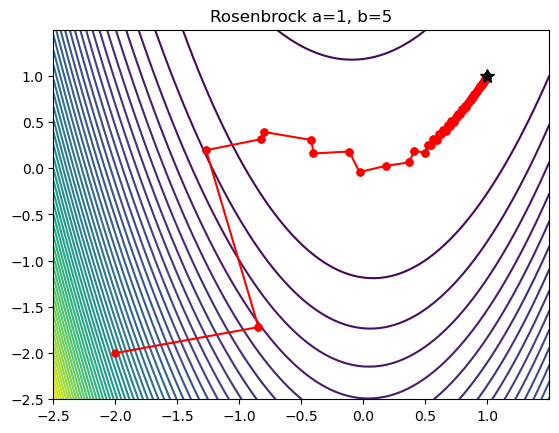

In [61]:
rosenbrock_points1 = get_points(rosenbrock, rosenbrock_gradient, [-2, -2])
draw_contour_and_descent(rosenbrock, rosenbrock_points1, (1,1), "Rosenbrock a=1, b=5")

From this graph we can see that QuasiNewton quickly finds the true minimum for the Rosenbrock function. There appear to be a bunch of small osicilations from (-1, -1.5) to the minimum which can be attrinbuted to decreasing values in the step value from the line search.